<a href="https://colab.research.google.com/github/yda-cyber/Hallucinator/blob/main/Hallucinator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install Dependencies
# @markdown Install ESMFold, OpenFold and Hallucinator
# @markdown - This will approximately use 5.5 minutes
# @markdown - ESMFold can be used from ESMFold API (online, without GPU). Typically Faster for small proteins.

useESMFold = "online" # @param ["local", "online"]

import os
import time

os.system("pip install pyKVFinder==0.6.0")
os.system("pip install numpy==1.23.5")
os.system("git clone https://github.com/yda-cyber/Hallucinator.git")

# Install ADFR
if not os.path.isfile('install-ADFR'):
  print("[PREPR]: Installing ADFR.")
  os.system("wget -O install-ADFR https://ccsb.scripps.edu/adfr/download/1028/")
  os.system("chmod a+x install-ADFR")
  !echo -e "Y\n ADFR" | ./install-ADFR >/dev/null 2>&1
  os.chdir('ADFR/')
  os.system('tar -zxvf ADFRsuite_x86_64Linux_1.0.tar.gz')
  os.chdir('ADFRsuite_x86_64Linux_1.0/')
  os.system('echo -e "Y" | ./install.sh >/dev/null 2>&1')
  os.system('cp bin/prepare_receptor ../../.')
  os.chdir('../..')

if not os.path.isfile('qvina-w'):
  print("[PREPR]: Installing Qvina-W.")
  os.system("git clone https://github.com/QVina/qvina.git")
  os.system("chmod +x qvina/bin/qvina-w")
  os.system("cp qvina/bin/qvina-w .")

os.makedirs("results", exist_ok=True)
os.makedirs("molecules", exist_ok=True)

if useESMFold == 'local':
  if not os.path.isfile("esmfold.model"):

    os.system("apt-get install aria2 -qq")
    print("[PREPR]: Downloading ESMFold from ColabFold.")
    os.system(f"aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/esmfold.model &")

    # wait for Params to finish downloading...
    if os.path.isfile(f"esmfold.model.aria2"):
      print("[PREPR]: Downloading in progress.")
    while os.path.isfile(f"esmfold.model.aria2"):
      time.sleep(5)

    if not os.path.isfile("FoldInstalled.state"):
      commit_id = "6908936b68ae89f67755240e2f588c09ec31d4c8"
      print("[PREPR]: Installing ESMfold Dependencies.")
      os.system("pip install -q omegaconf \"pytorch_lightning<2\" \"torch<2\" biopython ml_collections einops py3Dmol")
      os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")
      os.system(f"pip install -q git+https://github.com/aqlaboratory/openfold.git@{commit_id}")
      print("[PREPR]: Installing ESMfold")
      os.system("pip install -q git+https://github.com/sokrypton/esm.git")
      os.system("touch FoldInstalled.state")

[PREPR]: Installing ADFR.
[PREPR]: Installing Qvina-W.


In [ ]:
#@title Import Losses and Modules

from Hallucinator.ProteinHallucination import Protein_History_MCMC_Logger

from Hallucinator.modules.Predict_ESM import predict_esm
from Hallucinator.modules.Compute_RMSD import compute_rmsd
from Hallucinator.modules.Init_Sequence import init_sequence
from Hallucinator.modules.Select_Mutation import select_mutation
from Hallucinator.modules.Mutations_BLOSUM62 import mutation_blosum62

from Hallucinator.loss.Loss_Function import LossFunction

from Hallucinator.loss.Compute_Cavity_Volume_Loss import CavityVolumeLoss
from Hallucinator.loss.Compute_Local_Distance_Loss import LocalDistanceLoss
from Hallucinator.loss.Compute_Secondary_Ratio_Loss import SecondaryRatioLoss
from Hallucinator.loss.Compute_Contact_Density_Loss import ContactDensityLoss
from Hallucinator.loss.Compute_Cavity_Similarity_Loss import CavitySimilarityLoss
from Hallucinator.loss.Compute_Cavity_Containing_Loss import CavityContainingLoss
from Hallucinator.loss.Compute_Protein_Containing_Loss import ProteinContainingLoss
from Hallucinator.loss.Compute_Preserve_Structure_Loss import PreserveStructureLoss
from Hallucinator.loss.Compute_Truncated_Average_PLDDT_Loss import TruncatedAveragePLDDTLoss
from Hallucinator.loss.Compute_Molecule_Binding_Affinity_Loss import MoleculeBindingAffinityLoss
from Hallucinator.loss.Compute_Cavity_Containing_Flexible_Loss import CavityContainingFlexibleLoss

In [14]:
#@title Choose Functions and Set Parameters
#@markdown Basic Settings
Jobname = 'UUID4' #@param {type:"string"}
Length = 80 #@param {type: "number"}
Steps = 10000 #@param {type: "number"}
Output_Render_Frequency = 100 #@param {type: 'number'}
Start_From_Known_Sequence = False #@param {type:"boolean"}
#@markdown - Only when you select to start from known sequence, the Intial Sequence and Preservation will be used
Initial_Sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
Preserved_Residues = "1; 10; 11" #@param {type:"string"}
#@markdown - Use ; to seperate unwanted amino acids
Exclude_Amino_Acid = "C;H" #@param {type:"string"}
#@markdown - Number of guesses before starting hallucination
N_Free_Guess = 0 #@param [0, 5, 10]
#@markdown - Rules for mixing multiple losses
Loss_Rule = 'Max' #@param ['Sum', 'Max']


In [22]:
PLDDTLoss = []
POSLoss = []
#@markdown Parameters for Truncated PLDDT Loss (With max loss=1)
Truncated_PLDDT_Loss = True #@param {type:"boolean"}
target =  80 #@param {type:"number"}
pldd_target = target

if Truncated_PLDDT_Loss:
  PLDDTLoss += [TruncatedAveragePLDDTLoss(30, target)]

#@markdown Parameters for Contact Density Loss:
#@markdown - Enhance numbers of contact in proteins to make it globular
#@markdown - Typically Value: 0.035 for L<=150, 0.015 for L<=400
Contact_Density_Loss = True #@param {type:"boolean"}
target = 0.035 #@param {type:"number"}
max_loss =  2 #@param {type:"number"}
activate_PLDDT = 30 #@param {type: "number"}
cdl_max_loss, cdl_target, cdl_activate = target, max_loss, activate_PLDDT

if Contact_Density_Loss:
  POSLoss += [ContactDensityLoss(target_density=cdl_target, max_loss=cdl_max_loss,
                 plddt_activate_value=cdl_activate)]

#@markdown Parameters for Explicit Binding Loss:
Explicit_Binding_Loss = True #@param {type:"boolean"}
#@markdown - Target value varies for different molecules
target =  10 #@param {type:"number"}
max_loss =  5 #@param {type:"number"}
activate_PLDDT = 50 #@param {type: "number"}
mbl_max_loss, mbl_target, mbl_activate = target, max_loss, activate_PLDDT
use_example = True #@param {type:"boolean"}

#@markdown - If you selected MBL (and not example), please upload the required file (Ligand in PDBQT Format). Examples are in Hallucinator/Molecules:
if Explicit_Binding_Loss and not use_example:
  from google.colab import files
  filename = files.upload()
  for f in filename:
    os.rename(f, f'molecules/{f}')
    print(f'Moved "{f}" to the ./molecules/ directory')
  mbl_file = 'molecules/'+f
if use_example:
  mbl_file = 'Hallucinator/molecules/example.pdbqt'

if Explicit_Binding_Loss:
  POSLoss += [MoleculeBindingAffinityLoss(mbl_file,
                      max_loss=mbl_max_loss, target_score=mbl_target,
                      plddt_activate_value=mbl_activate)]

#@markdown Parameters for Implicit Cavity Loss:
Implicit_Cavity_Loss = False #@param {type:"boolean"}
#@markdown - Target value varies for different molecules
Tolerate_Volume_Diff =  500 #@param {type:"number"}
#@markdown - Smaller Step will make cavity calculation more accurate but also more expensive
Step_KVFinder = 0.6 #@param {type:"number"}
#@markdown - Whether sidechains are ignored when calculating cavities.
Ignore_Sidechains = False #@param {type: "boolean"}
max_loss =  5 #@param {type:"number"}
activate_PLDDT = 50 #@param {type: "number"}
ccl_max_loss, ccl_activate = max_loss, activate_PLDDT
use_example = True #@param {type:"boolean"}

#@markdown - If you selected ICL (and not example), please upload the required file (Ligand in PDB Format, the Occ column to be vdw radius). Examples are in Hallucinator/Molecules:
if Implicit_Cavity_Loss and not use_example:
  from google.colab import files
  filename = files.upload()
  for f in filename:
    os.rename(f, f'molecules/{f}')
    print(f'Moved "{f}" to the ./molecules/ directory')
  ccl_file = 'molecules'+ f
if use_example:
  ccl_file = 'Hallucinator/molecules/example.pdb'

if Implicit_Cavity_Loss:
  POSLoss += [CavitySimilarityLoss(ccl_file, volume_factor=0.01,
                  volume_expansion=Tolerate_Volume_Diff,
                  similarity_factor=20, similarity_target_diff=0,
                  sample_points=10, step_guest=0.2,
                  step_protein=Step_KVFinder,
                  backbone_cavity=Ignore_Sidechains,
                  max_loss=ccl_max_loss, plddt_activate_value=ccl_activate)]

Saving Methoxypromazine.pdb to Methoxypromazine.pdb
Moved "Methoxypromazine.pdb" to the ./molecules/ directory


INFO:Logger:[JOBID]: Start with job name fb606c9a.
INFO:Logger:[RANDS]: Random seed set as 794482155
INFO:Logger:[SECIT]: Initial Sequence Random Generated.


[CSLOG]: Targeted volume is 177.98


INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 0.22, 'Diff volume': 168.69, 'ConFactor': (0.96, 1.0, 1)}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 0.18, 'Diff volume': 632.88, 'ConFactor': (0.09, 0.04, 0.79)}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 0.65, 'Diff volume': 384.05, 'ConFactor': (0.48, 0.99, 1)}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 0.14, 'Error': 'pos loss'}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 0.97, 'Diff volume': 42.99, 'ConFactor': (0.3, 0.75, 0.0)}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 1.05, 'Error': 'pos loss'}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 0.07, 'Diff volume': 25.49, 'ConFactor': (0.47, 0.99, 1)}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 0.22, 'Diff volume': 58.76, 'ConFactor': (0.25, 0.49, 0.0)}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 0.04, 'Diff volume': 1421.5, 'ConFactor': (0.19, 0

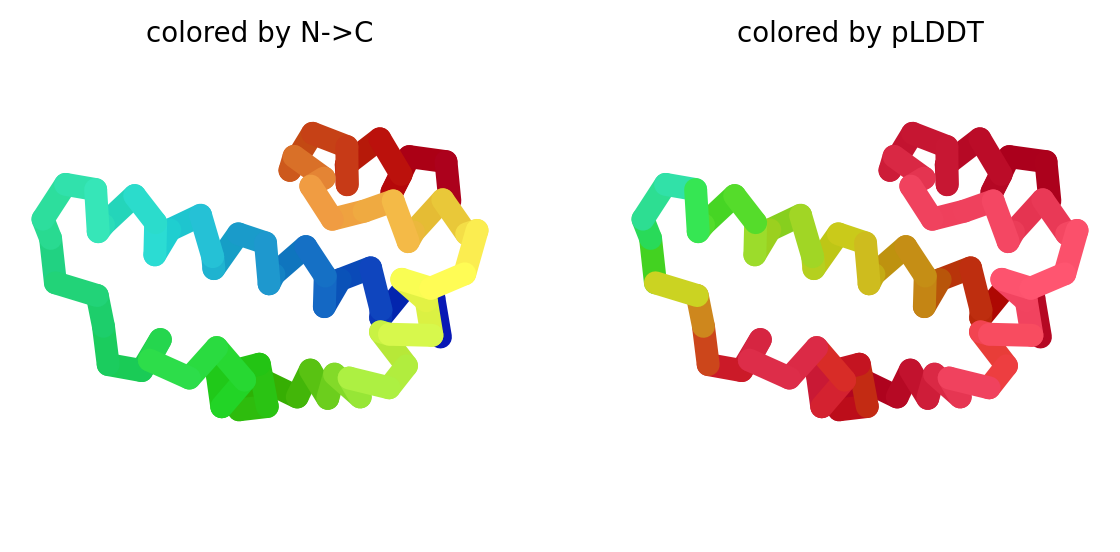

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 52.48, 'Contact %': 0.72, 'Diff volume': 64.8, 'ConFactor': ('Unstable', 1, 0.0)}
INFO:Logger:[MCLOG]: Step: 101, New Loss: 0.531, Curr Loss: 0.220, Best Loss: 0.220, Accepted: × with temp 2.2 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 47.22, 'Contact %': 0.86}
INFO:Logger:[MCLOG]: Step: 102, New Loss: 0.835, Curr Loss: 0.220, Best Loss: 0.220, Accepted: × with temp 2.3 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 52.85, 'Contact %': 1.48, 'Diff volume': 87.48, 'ConFactor': (0.18, 0.46, 0.01)}
INFO:Logger:[MCLOG]: Step: 103, New Loss: 0.269, Curr Loss: 0.220, Best Loss: 0.220, Accepted: × with temp 2.4 and prob 0.128
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 48.94, 'Contact %': 0.61}
INFO:Logger:[MCLOG]: Step: 104, New Loss: 0.863, Curr Loss: 0.220, Best Loss: 0.220, Accepted: × with temp 2.5 and prob 0.000
INFO:Logger:[LSLOG]: Following info retur

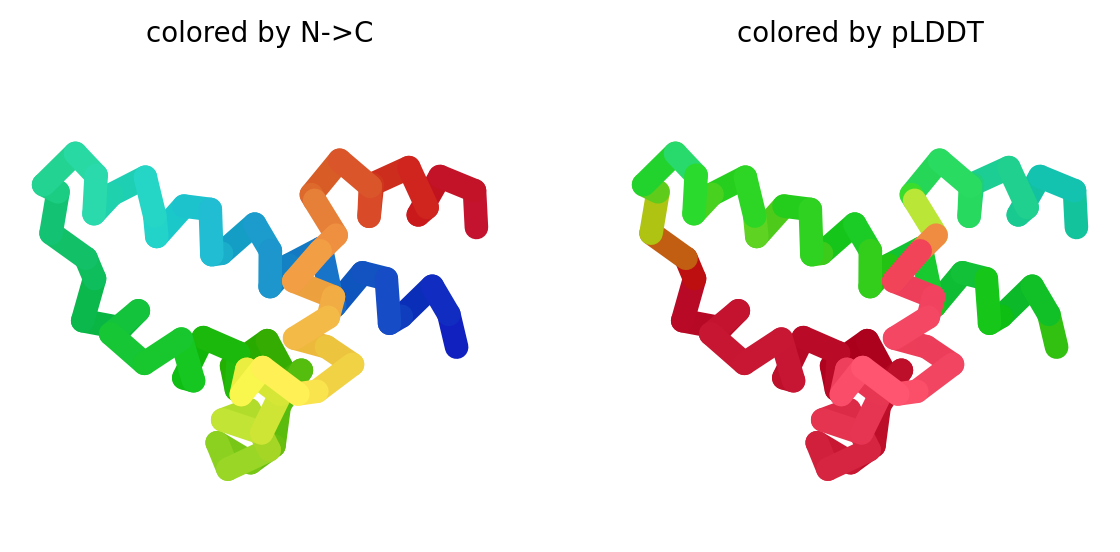

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 48.31, 'Contact %': 0.72}
INFO:Logger:[MCLOG]: Step: 201, New Loss: 0.851, Curr Loss: 0.143, Best Loss: 0.143, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 59.39, 'Contact %': 1.48, 'Diff volume': 82.52, 'ConFactor': (0.18, 0.56, 0.0)}
INFO:Logger:[MCLOG]: Step: 202, New Loss: 0.285, Curr Loss: 0.143, Best Loss: 0.143, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 56.91, 'Contact %': 1.59, 'Diff volume': 93.96, 'ConFactor': (0.12, 0.23, 0.01)}
INFO:Logger:[MCLOG]: Step: 203, New Loss: 0.174, Curr Loss: 0.143, Best Loss: 0.143, Accepted: × with temp 1.0 and prob 0.045
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 58.21, 'Contact %': 1.51, 'Diff volume': 193.97, 'ConFactor': (0.23, 1, 0.03)}
INFO:Logger:[MCLOG]: Step: 204, New Loss: 0.429, Curr Loss: 0.143, Best Loss: 0.143, Accepted: × with temp 1.0 and p

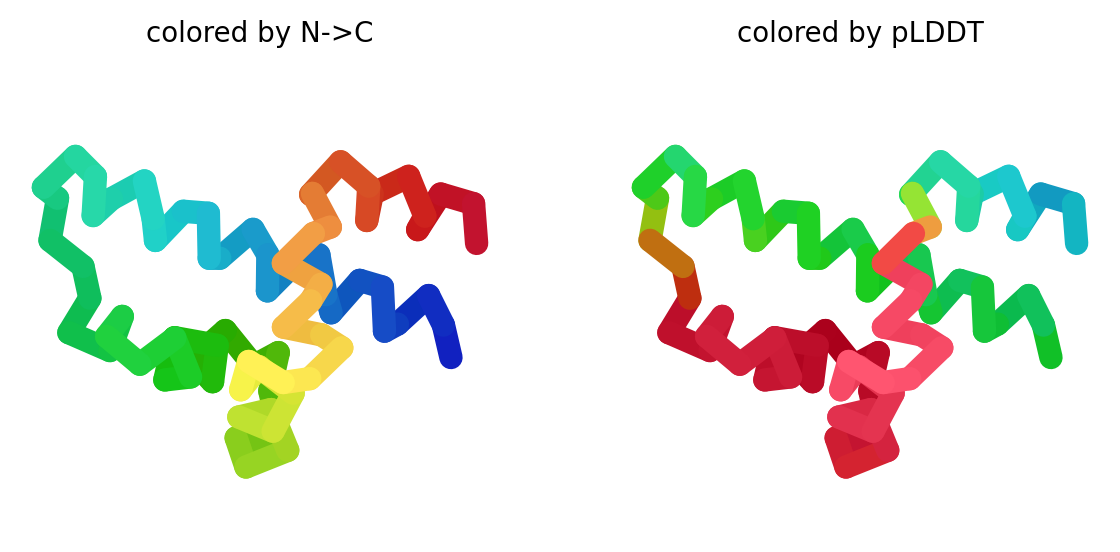

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 55.11, 'Contact %': 0.97, 'Diff volume': 83.37, 'ConFactor': (0.54, 1, 1)}
INFO:Logger:[MCLOG]: Step: 301, New Loss: 0.805, Curr Loss: 0.187, Best Loss: 0.143, Accepted: × with temp 5.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 62.09, 'Contact %': 1.48, 'Diff volume': 150.12, 'ConFactor': (0.36, 1, 0.02)}
INFO:Logger:[MCLOG]: Step: 302, New Loss: 0.421, Curr Loss: 0.187, Best Loss: 0.143, Accepted: × with temp 5.0 and prob 0.009
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 49.1, 'Contact %': 0.79}
INFO:Logger:[MCLOG]: Step: 303, New Loss: 0.840, Curr Loss: 0.187, Best Loss: 0.143, Accepted: × with temp 5.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 48.61, 'Contact %': 0.79}
INFO:Logger:[MCLOG]: Step: 304, New Loss: 0.841, Curr Loss: 0.187, Best Loss: 0.143, Accepted: × with temp 5.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave

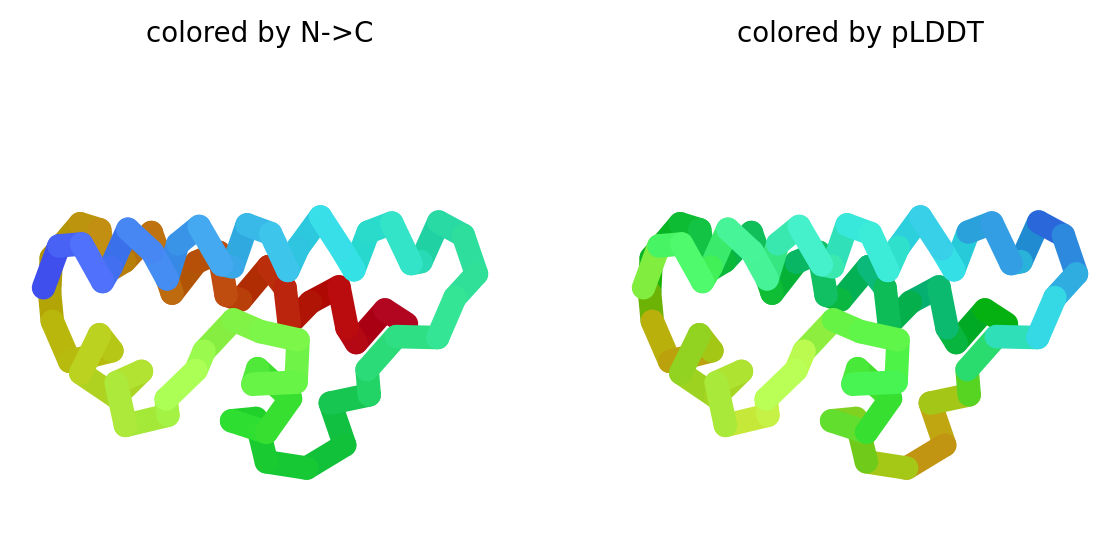

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 50.88, 'Contact %': 0.9, 'Error': 'pos loss'}
INFO:Logger:[MCLOG]: Step: 401, New Loss: 0.823, Curr Loss: 0.091, Best Loss: 0.085, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 55.32, 'Contact %': 1.41, 'Diff volume': 42.34, 'ConFactor': (0.45, 1, 1)}
INFO:Logger:[MCLOG]: Step: 402, New Loss: 0.751, Curr Loss: 0.091, Best Loss: 0.085, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 64.55, 'Contact %': 2.09, 'Diff volume': 27.87, 'ConFactor': (0.18, 0.32, 0.0)}
INFO:Logger:[MCLOG]: Step: 403, New Loss: 0.134, Curr Loss: 0.091, Best Loss: 0.085, Accepted: × with temp 1.0 and prob 0.015
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 70.65, 'Contact %': 2.2, 'Diff volume': 16.64, 'ConFactor': (0.15, 0.17, 0.0)}
INFO:Logger:[MCLOG]: Step: 404, New Loss: 0.073, Curr Loss: 0.073, Best Loss: 0.073, Accepted: √ with 

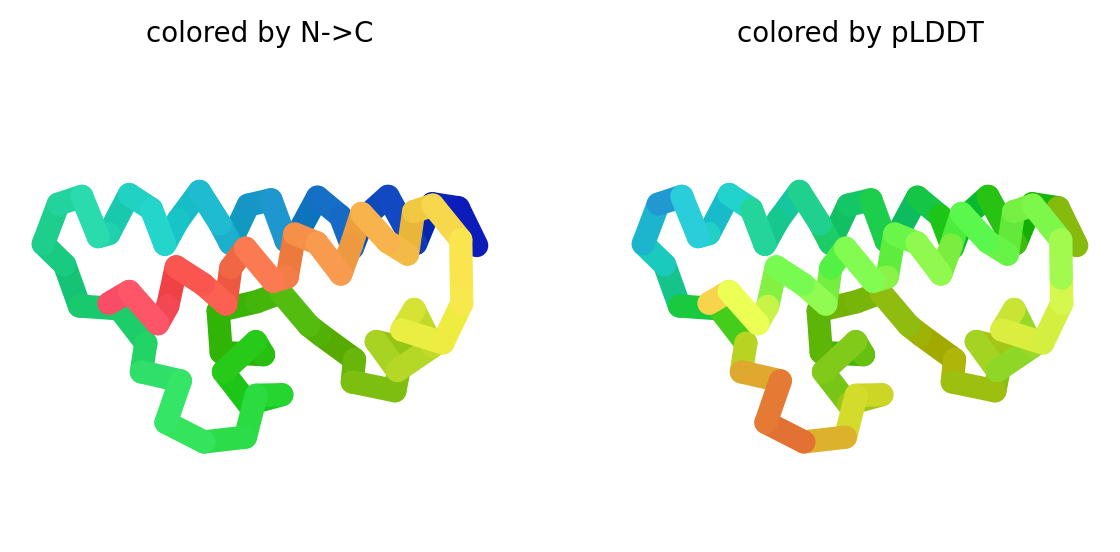

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 76.62, 'Contact %': 2.05, 'Diff volume': 4.32, 'ConFactor': (0.2, 0.3, 0.0)}
INFO:Logger:[MCLOG]: Step: 501, New Loss: 0.101, Curr Loss: 0.053, Best Loss: 0.053, Accepted: × with temp 1.0 and prob 0.008
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 70.46, 'Contact %': 2.13, 'Diff volume': 27.22, 'ConFactor': (0.17, 0.21, 0.0)}
INFO:Logger:[MCLOG]: Step: 502, New Loss: 0.085, Curr Loss: 0.053, Best Loss: 0.053, Accepted: × with temp 1.0 and prob 0.038
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 53.68, 'Contact %': 1.26, 'Diff volume': 753.63, 'ConFactor': (0.19, 0.82, 0.93)}
INFO:Logger:[MCLOG]: Step: 503, New Loss: 0.693, Curr Loss: 0.053, Best Loss: 0.053, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 72.91, 'Contact %': 2.13, 'Diff volume': 4.76, 'ConFactor': (0.22, 0.46, 0.0)}
INFO:Logger:[MCLOG]: Step: 504, New Loss: 0.160, Curr Loss: 0.05

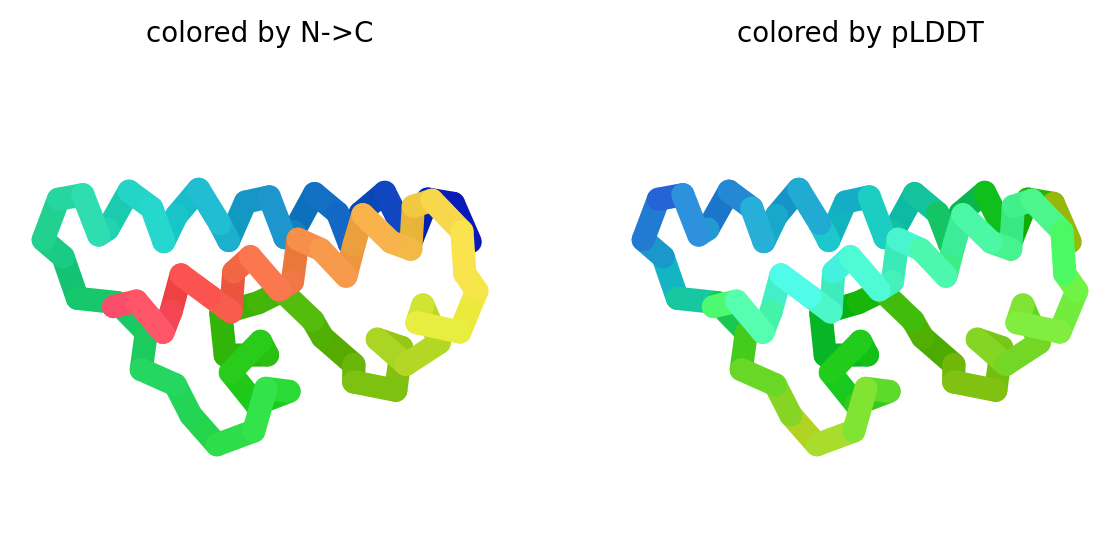

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 54.92, 'Contact %': 0.22, 'Diff volume': 25.92, 'ConFactor': (0.19, 0.53, 0.0)}
INFO:Logger:[MCLOG]: Step: 601, New Loss: 0.442, Curr Loss: 0.032, Best Loss: 0.015, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 52.61, 'Contact %': 0.14, 'Diff volume': 607.18, 'ConFactor': (0.17, 0.59, 0.74)}
INFO:Logger:[MCLOG]: Step: 602, New Loss: 0.704, Curr Loss: 0.032, Best Loss: 0.015, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 74.25, 'Contact %': 2.27, 'Diff volume': 8.64, 'ConFactor': (0.2, 0.33, 0.0)}
INFO:Logger:[MCLOG]: Step: 603, New Loss: 0.114, Curr Loss: 0.032, Best Loss: 0.015, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 55.25, 'Contact %': 1.55, 'Diff volume': 1.95, 'ConFactor': (0.44, 1, 1)}
INFO:Logger:[MCLOG]: Step: 604, New Loss: 0.733, Curr Loss: 0.032, B

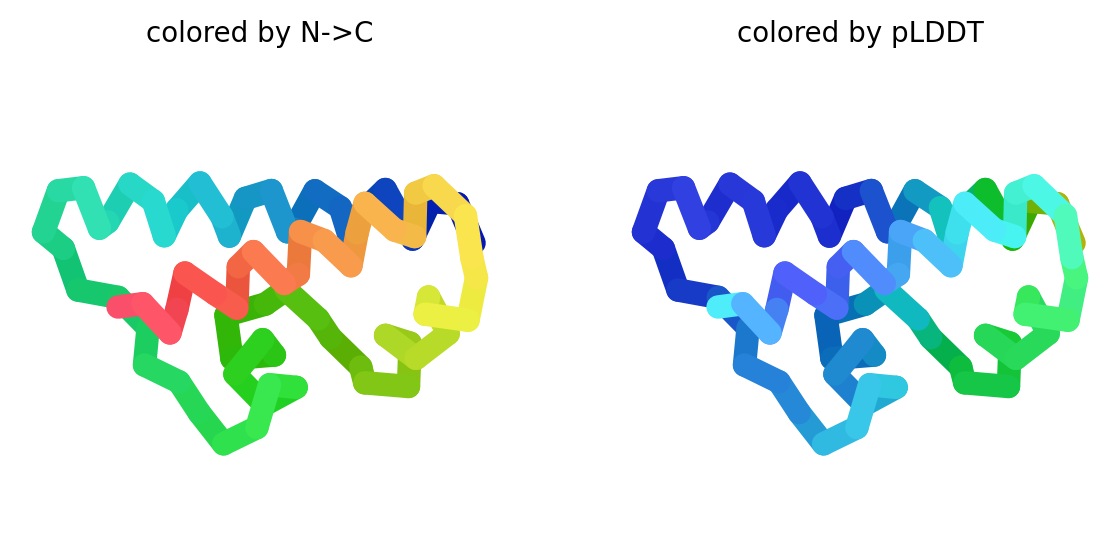

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 47.82, 'Contact %': 1.33}
INFO:Logger:[MCLOG]: Step: 701, New Loss: 0.775, Curr Loss: 0.011, Best Loss: 0.011, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 83.95, 'Contact %': 2.34, 'Diff volume': 4.75, 'ConFactor': (0.24, 0.46, 0.0)}
INFO:Logger:[MCLOG]: Step: 702, New Loss: 0.143, Curr Loss: 0.011, Best Loss: 0.011, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 50.65, 'Contact %': 1.37, 'Diff volume': 205.64, 'ConFactor': ('Unstable', 1, 0.04)}
INFO:Logger:[MCLOG]: Step: 703, New Loss: 0.464, Curr Loss: 0.011, Best Loss: 0.011, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 79.86, 'Contact %': 2.2, 'Diff volume': 160.05, 'ConFactor': (0.92, 1, 1)}
INFO:Logger:[MCLOG]: Step: 704, New Loss: 0.625, Curr Loss: 0.011, Best Loss: 0.011, Accepted: × with temp 1.0 and pr

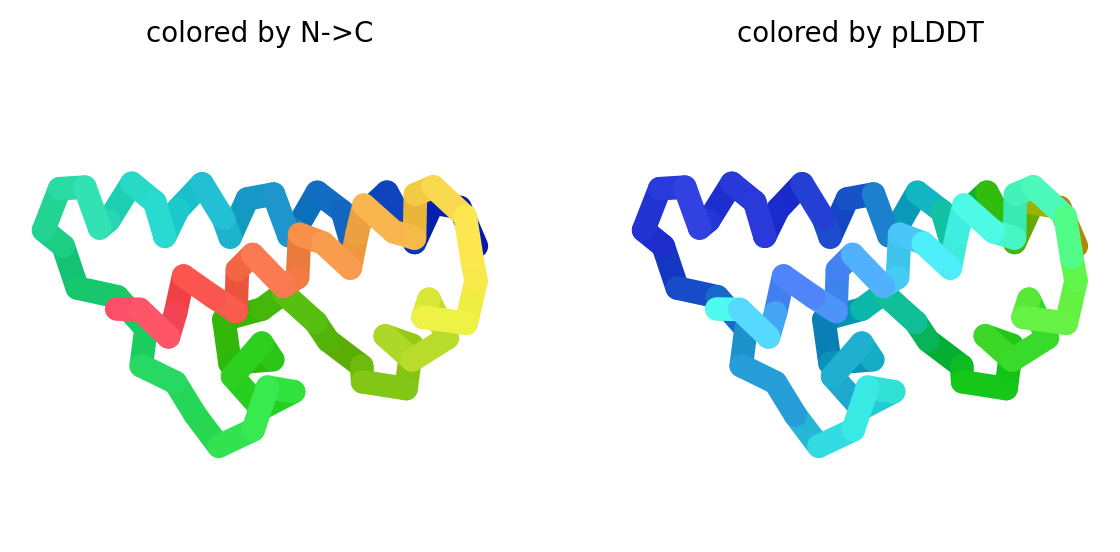

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 49.34, 'Contact %': 1.19}
INFO:Logger:[MCLOG]: Step: 801, New Loss: 0.790, Curr Loss: 0.015, Best Loss: 0.011, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 50.2, 'Contact %': 1.19, 'Diff volume': 234.15, 'ConFactor': ('Unstable', 1, 0.05)}
INFO:Logger:[MCLOG]: Step: 802, New Loss: 0.493, Curr Loss: 0.015, Best Loss: 0.011, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 45.31, 'Contact %': 1.05}
INFO:Logger:[MCLOG]: Step: 803, New Loss: 0.817, Curr Loss: 0.015, Best Loss: 0.011, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 47.7, 'Contact %': 0.61}
INFO:Logger:[MCLOG]: Step: 804, New Loss: 0.866, Curr Loss: 0.015, Best Loss: 0.011, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 80.19, 'Contact %': 2.31, 'Diff vol

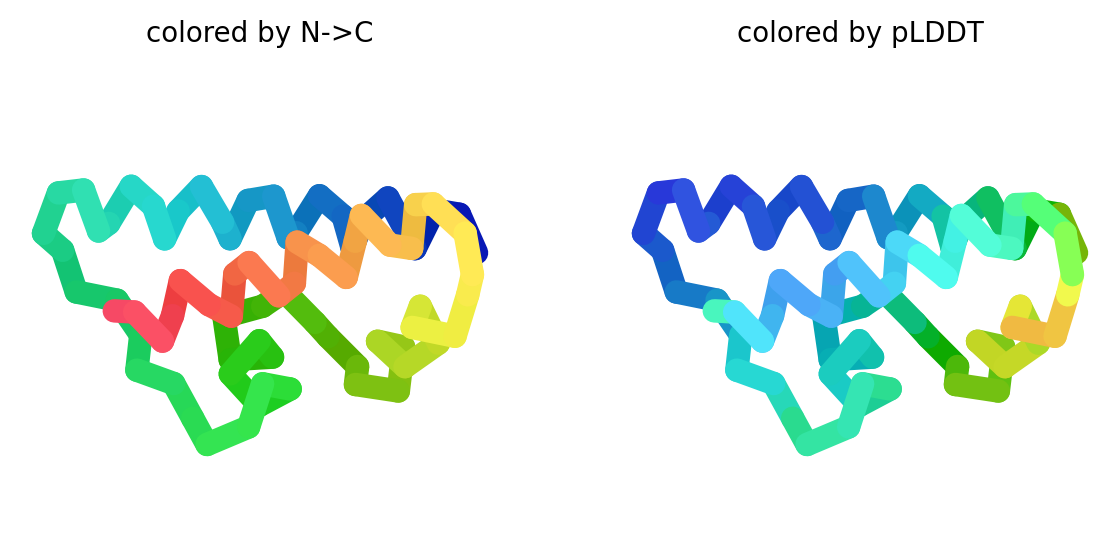

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 41.76, 'Contact %': 0.5}
INFO:Logger:[MCLOG]: Step: 901, New Loss: 0.892, Curr Loss: 0.020, Best Loss: 0.011, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 44.11, 'Contact %': 1.15}
INFO:Logger:[MCLOG]: Step: 902, New Loss: 0.806, Curr Loss: 0.020, Best Loss: 0.011, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 42.98, 'Contact %': 0.94}
INFO:Logger:[MCLOG]: Step: 903, New Loss: 0.835, Curr Loss: 0.020, Best Loss: 0.011, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 45.61, 'Contact %': 1.3}
INFO:Logger:[MCLOG]: Step: 904, New Loss: 0.784, Curr Loss: 0.020, Best Loss: 0.011, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 40.96, 'Contact %': 0.83}
INFO:Logger:[MCLOG]: Step: 905, New Loss: 0.853, Curr Loss: 0.020, B

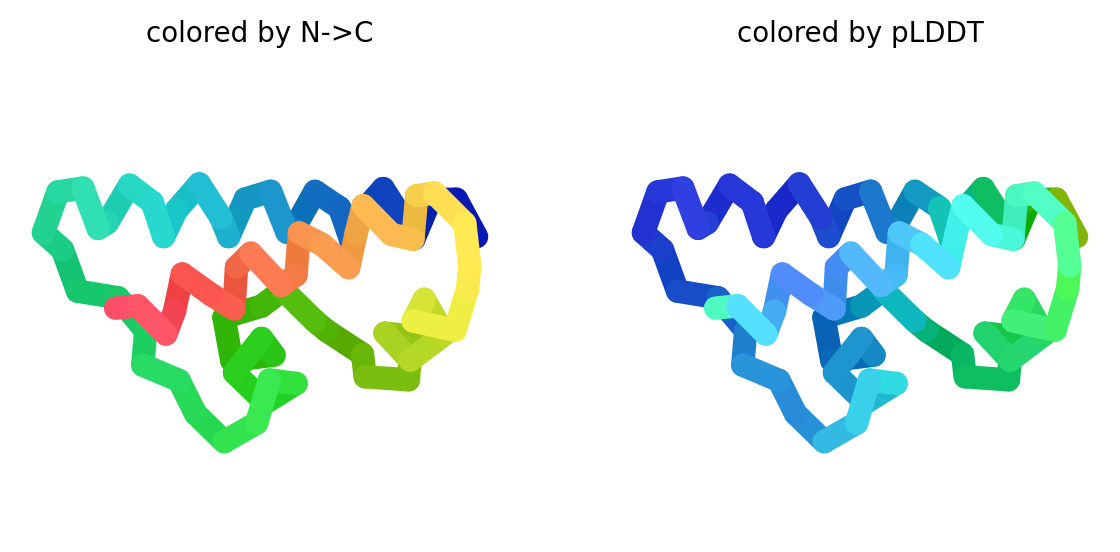

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 66.5, 'Contact %': 2.56, 'Diff volume': 148.17, 'ConFactor': (0.86, 1, 1)}
INFO:Logger:[MCLOG]: Step: 1001, New Loss: 0.653, Curr Loss: 0.010, Best Loss: 0.010, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 41.91, 'Contact %': 0.79}
INFO:Logger:[MCLOG]: Step: 1002, New Loss: 0.855, Curr Loss: 0.010, Best Loss: 0.010, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 41.3, 'Contact %': 0.83}
INFO:Logger:[MCLOG]: Step: 1003, New Loss: 0.852, Curr Loss: 0.010, Best Loss: 0.010, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 60.75, 'Contact %': 2.27, 'Diff volume': 105.84, 'ConFactor': (0.09, 0.09, 0.01)}
INFO:Logger:[MCLOG]: Step: 1004, New Loss: 0.070, Curr Loss: 0.010, Best Loss: 0.010, Accepted: × with temp 1.0 and prob 0.003
INFO:Logger:[LSLOG]: Following info returned

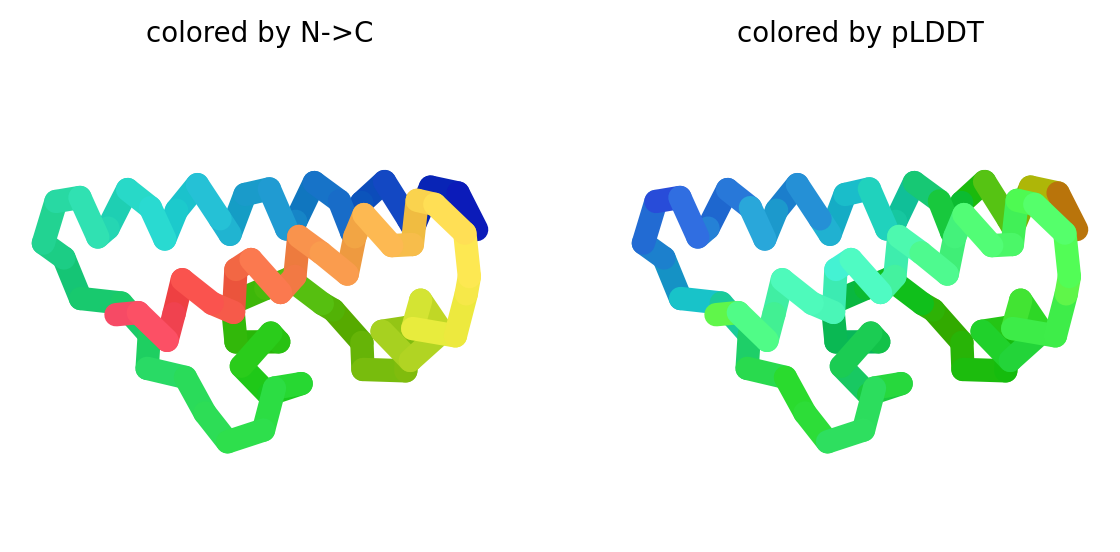

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 57.59, 'Contact %': 1.84, 'Diff volume': 70.85, 'ConFactor': (0.15, 0.21, 0.0)}
INFO:Logger:[MCLOG]: Step: 1101, New Loss: 0.133, Curr Loss: 0.034, Best Loss: 0.010, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 44.3, 'Contact %': 0.86}
INFO:Logger:[MCLOG]: Step: 1102, New Loss: 0.841, Curr Loss: 0.034, Best Loss: 0.010, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 81.69, 'Contact %': 2.16, 'Diff volume': 71.07, 'ConFactor': (0.11, 0.07, 0.0)}
INFO:Logger:[MCLOG]: Step: 1103, New Loss: 0.023, Curr Loss: 0.023, Best Loss: 0.010, Accepted: √ with temp 1.0 and prob 1.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 84.62, 'Contact %': 2.05, 'Diff volume': 51.63, 'ConFactor': (0.14, 0.11, 0.0)}
INFO:Logger:[MCLOG]: Step: 1104, New Loss: 0.036, Curr Loss: 0.023, Best Loss: 0.010, Accepted: × with temp 1.0 an

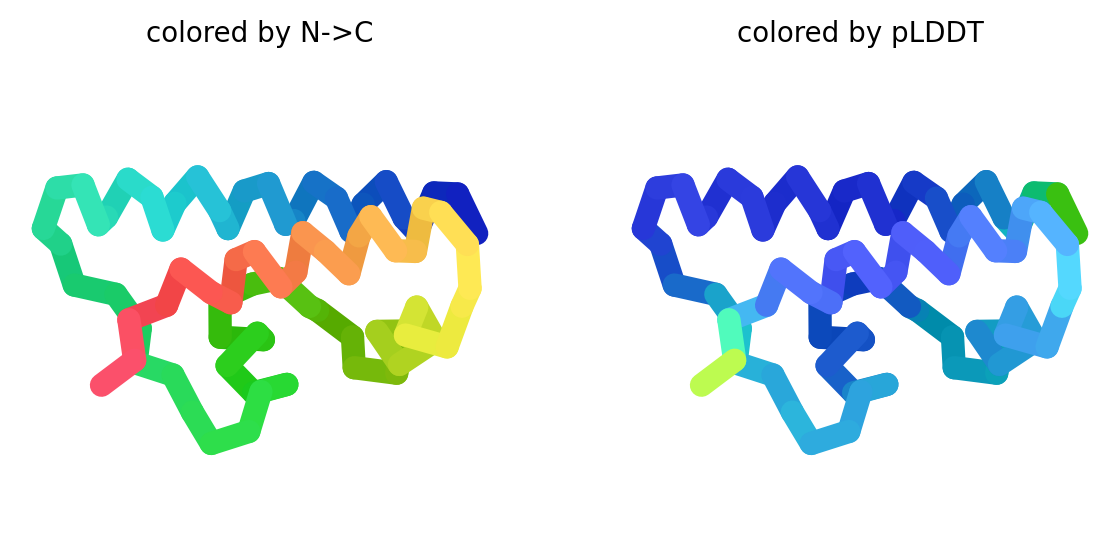

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 87.69, 'Contact %': 2.23, 'Diff volume': 157.68, 'ConFactor': (0.91, 1.0, 1)}
INFO:Logger:[MCLOG]: Step: 1201, New Loss: 0.625, Curr Loss: 0.028, Best Loss: 0.010, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 41.55, 'Contact %': 0.72}
INFO:Logger:[MCLOG]: Step: 1202, New Loss: 0.865, Curr Loss: 0.028, Best Loss: 0.010, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 63.54, 'Contact %': 1.98, 'Diff volume': 162.21, 'ConFactor': (0.94, 1, 1)}
INFO:Logger:[MCLOG]: Step: 1203, New Loss: 0.662, Curr Loss: 0.028, Best Loss: 0.010, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 86.32, 'Contact %': 2.16, 'Diff volume': 22.03, 'ConFactor': (0.37, 0.91, 0.0)}
INFO:Logger:[MCLOG]: Step: 1204, New Loss: 0.285, Curr Loss: 0.028, Best Loss: 0.010, Accepted: × with temp 1.0 and pro

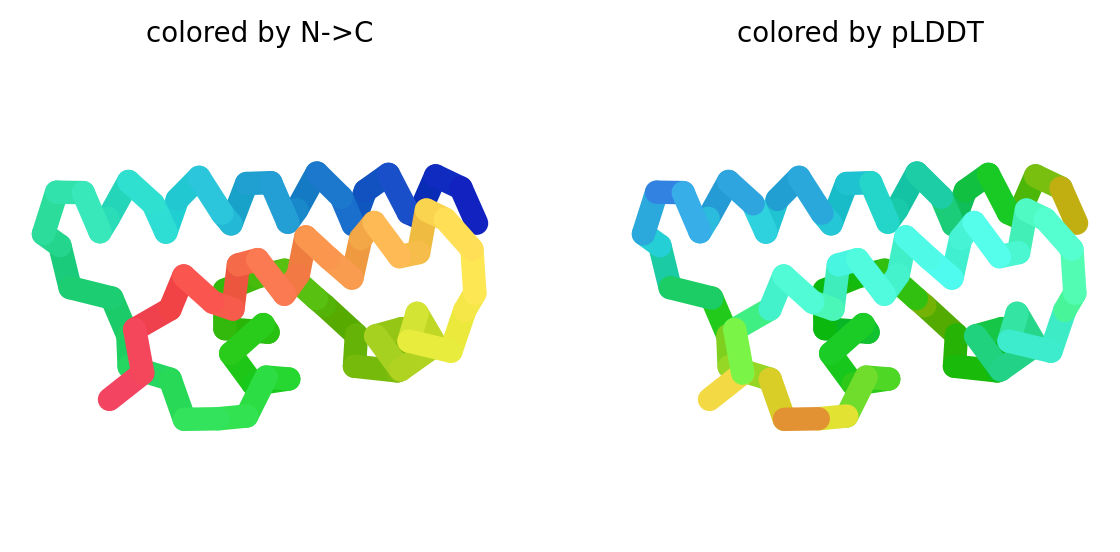

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 47.71, 'Contact %': 0.43}
INFO:Logger:[MCLOG]: Step: 1301, New Loss: 0.888, Curr Loss: 0.022, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 50.5, 'Contact %': 1.01, 'Error': 'pos loss'}
INFO:Logger:[MCLOG]: Step: 1302, New Loss: 0.810, Curr Loss: 0.022, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 50.62, 'Contact %': 0.79, 'Error': 'pos loss'}
INFO:Logger:[MCLOG]: Step: 1303, New Loss: 0.837, Curr Loss: 0.022, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 47.88, 'Contact %': 0.47}
INFO:Logger:[MCLOG]: Step: 1304, New Loss: 0.883, Curr Loss: 0.022, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 47.26, 'Contact %': 0.58}
INFO:Logger:[MCLOG]: 

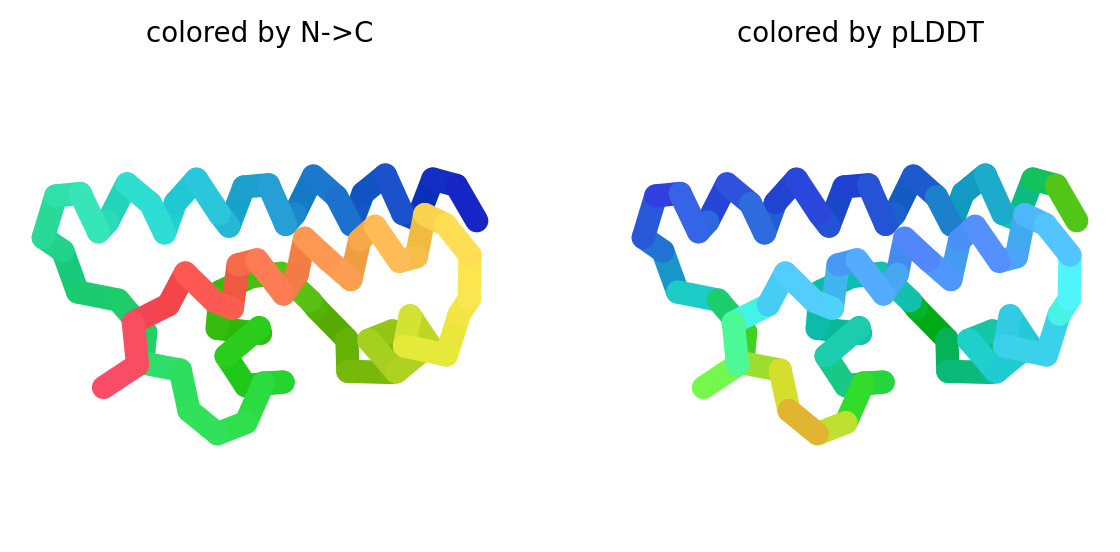

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 77.96, 'Contact %': 2.34, 'Diff volume': 165.67, 'ConFactor': (0.95, 1, 1)}
INFO:Logger:[MCLOG]: Step: 1401, New Loss: 0.629, Curr Loss: 0.015, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 43.64, 'Contact %': 0.65}
INFO:Logger:[MCLOG]: Step: 1402, New Loss: 0.870, Curr Loss: 0.015, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 84.38, 'Contact %': 2.27, 'Diff volume': 31.76, 'ConFactor': (0.12, 0.07, 0.0)}
INFO:Logger:[MCLOG]: Step: 1403, New Loss: 0.023, Curr Loss: 0.023, Best Loss: 0.009, Accepted: √ with temp 1.0 and prob 0.450
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 45.84, 'Contact %': 0.32}
INFO:Logger:[MCLOG]: Step: 1404, New Loss: 0.906, Curr Loss: 0.023, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned

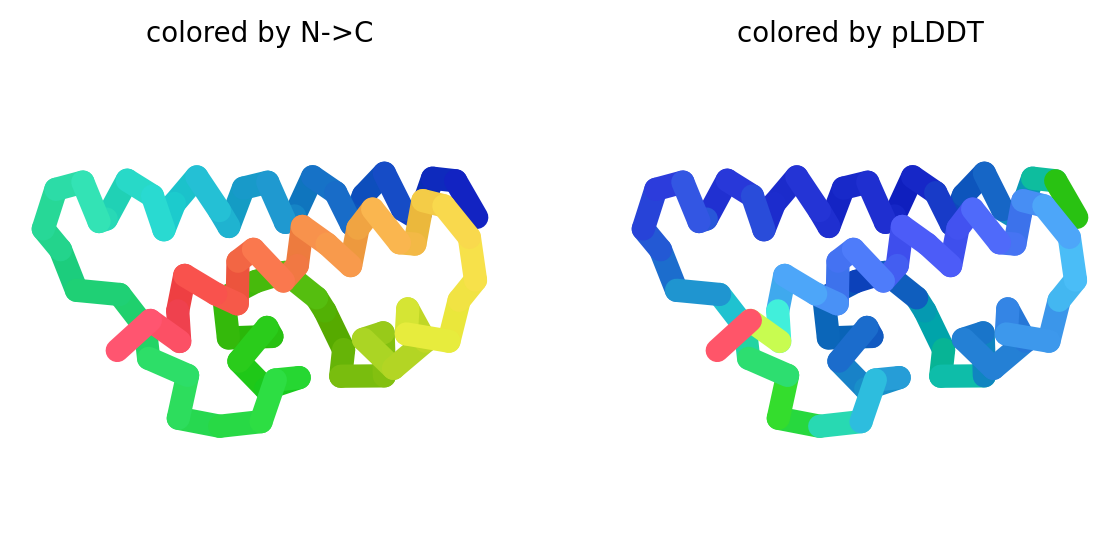

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 76.86, 'Contact %': 2.23, 'Diff volume': 64.58, 'ConFactor': (0.42, 1, 1)}
INFO:Logger:[MCLOG]: Step: 1501, New Loss: 0.632, Curr Loss: 0.029, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 49.05, 'Contact %': 1.19}
INFO:Logger:[MCLOG]: Step: 1502, New Loss: 0.791, Curr Loss: 0.029, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 54.55, 'Contact %': 1.73, 'Diff volume': 104.54, 'ConFactor': ('Unstable', 1, 1)}
INFO:Logger:[MCLOG]: Step: 1503, New Loss: 0.712, Curr Loss: 0.029, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 85.98, 'Contact %': 2.02, 'Diff volume': 6.05, 'ConFactor': (0.2, 0.28, 0.0)}
INFO:Logger:[MCLOG]: Step: 1504, New Loss: 0.089, Curr Loss: 0.029, Best Loss: 0.009, Accepted: × with temp 1.0 and pr

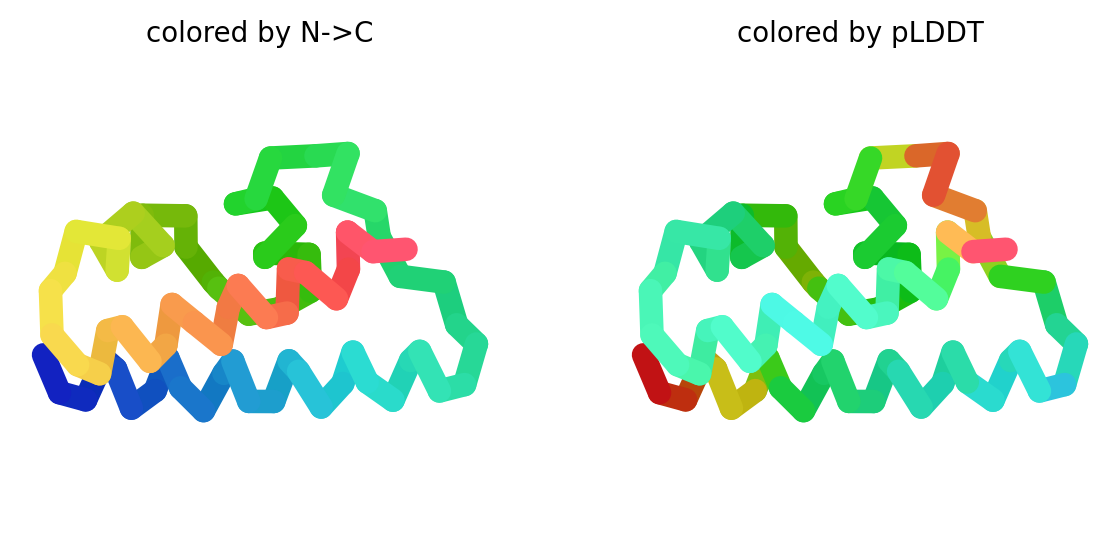

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 46.19, 'Contact %': 1.08}
INFO:Logger:[MCLOG]: Step: 1601, New Loss: 0.810, Curr Loss: 0.039, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 58.81, 'Contact %': 1.95, 'Error': 'pos loss'}
INFO:Logger:[MCLOG]: Step: 1602, New Loss: 0.676, Curr Loss: 0.039, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 46.45, 'Contact %': 1.01}
INFO:Logger:[MCLOG]: Step: 1603, New Loss: 0.819, Curr Loss: 0.039, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 44.69, 'Contact %': 1.08}
INFO:Logger:[MCLOG]: Step: 1604, New Loss: 0.813, Curr Loss: 0.039, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 44.15, 'Contact %': 0.54}
INFO:Logger:[MCLOG]: Step: 1605, New Loss

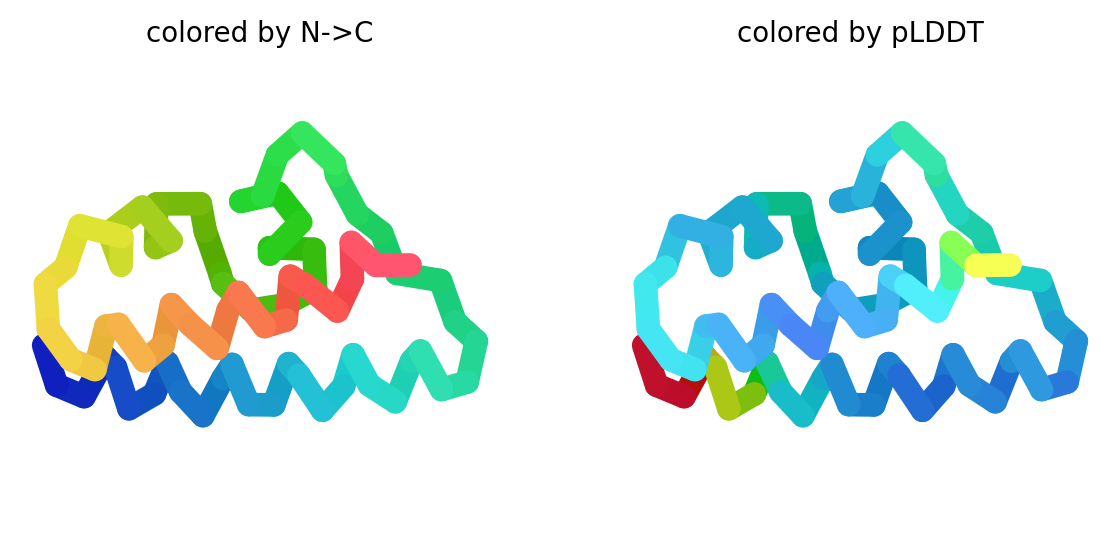

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 44.68, 'Contact %': 0.79}
INFO:Logger:[MCLOG]: Step: 1701, New Loss: 0.849, Curr Loss: 0.065, Best Loss: 0.009, Accepted: × with temp 1.2 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 82.9, 'Contact %': 2.09, 'Diff volume': 152.92, 'ConFactor': (0.87, 1, 1)}
INFO:Logger:[MCLOG]: Step: 1702, New Loss: 0.625, Curr Loss: 0.065, Best Loss: 0.009, Accepted: × with temp 1.2 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 45.65, 'Contact %': 0.83}
INFO:Logger:[MCLOG]: Step: 1703, New Loss: 0.843, Curr Loss: 0.065, Best Loss: 0.009, Accepted: × with temp 1.2 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 78.04, 'Contact %': 1.95, 'Diff volume': 68.69, 'ConFactor': (0.09, 0.05, 0.0)}
INFO:Logger:[MCLOG]: Step: 1704, New Loss: 0.029, Curr Loss: 0.029, Best Loss: 0.009, Accepted: √ with temp 1.3 and prob 1.000
INFO:Logger:[LSLOG]: Following info returned:

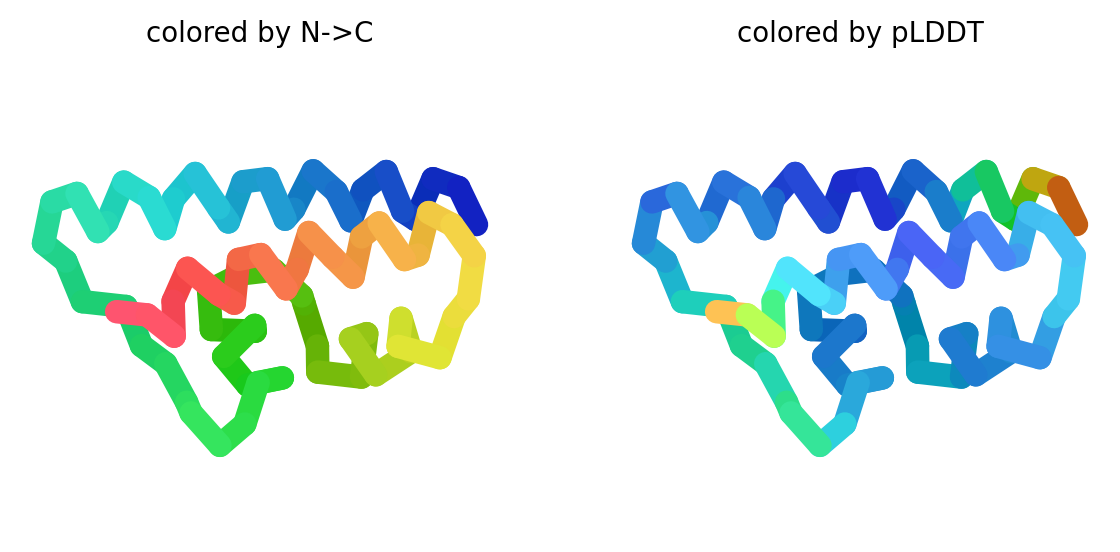

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 78.78, 'Contact %': 2.09, 'Diff volume': 4.11, 'ConFactor': (0.2, 0.26, 0.0)}
INFO:Logger:[MCLOG]: Step: 1801, New Loss: 0.084, Curr Loss: 0.042, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.015
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 44.41, 'Contact %': 0.65}
INFO:Logger:[MCLOG]: Step: 1802, New Loss: 0.868, Curr Loss: 0.042, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 63.19, 'Contact %': 2.27, 'Error': 'pos loss'}
INFO:Logger:[MCLOG]: Step: 1803, New Loss: 0.660, Curr Loss: 0.042, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 79.94, 'Contact %': 2.16, 'Diff volume': 164.37, 'ConFactor': (0.94, 1, 1)}
INFO:Logger:[MCLOG]: Step: 1804, New Loss: 0.625, Curr Loss: 0.042, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Foll

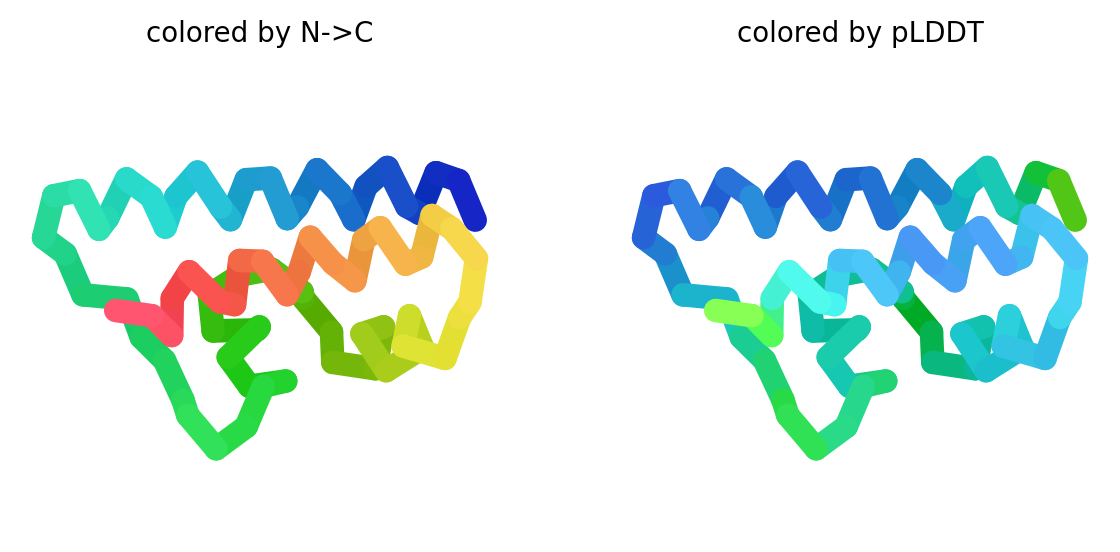

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 45.3, 'Contact %': 0.72}
INFO:Logger:[MCLOG]: Step: 1901, New Loss: 0.857, Curr Loss: 0.009, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 70.86, 'Contact %': 2.02, 'Diff volume': 71.07, 'ConFactor': (0.13, 0.11, 0.0)}
INFO:Logger:[MCLOG]: Step: 1902, New Loss: 0.055, Curr Loss: 0.009, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.010
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 66.9, 'Contact %': 1.87, 'Diff volume': 95.48, 'ConFactor': (0.08, 0.06, 0.01)}
INFO:Logger:[MCLOG]: Step: 1903, New Loss: 0.062, Curr Loss: 0.009, Best Loss: 0.009, Accepted: × with temp 1.0 and prob 0.005
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 64.36, 'Contact %': 2.16, 'Diff volume': 158.76, 'ConFactor': (0.91, 1, 1)}
INFO:Logger:[MCLOG]: Step: 1904, New Loss: 0.658, Curr Loss: 0.009, Best Loss: 0.009, Accepted: × with temp 1.0 and pr

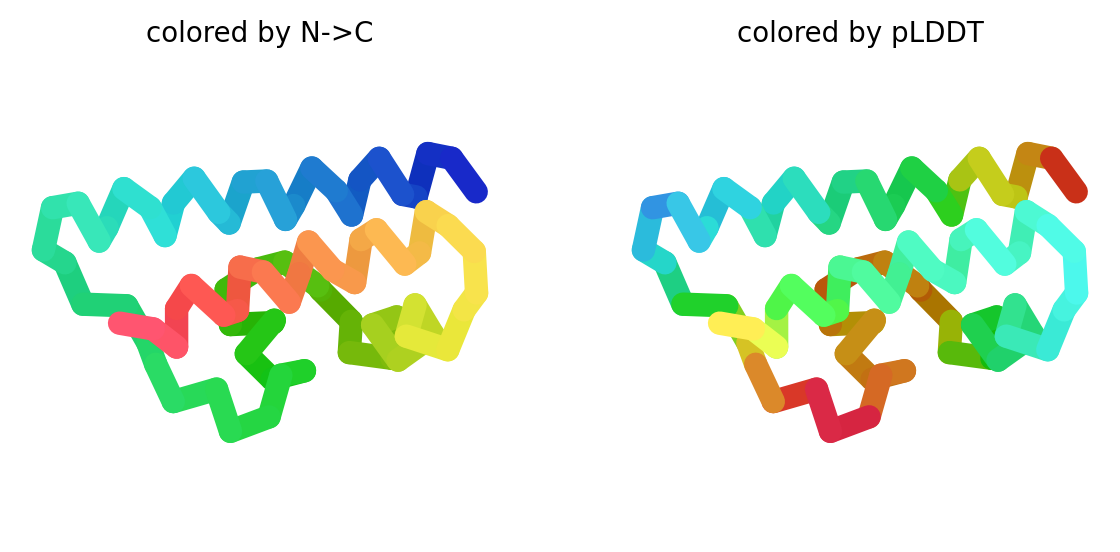

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 49.26, 'Contact %': 0.94}
INFO:Logger:[MCLOG]: Step: 2001, New Loss: 0.822, Curr Loss: 0.040, Best Loss: 0.008, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 46.82, 'Contact %': 0.94}
INFO:Logger:[MCLOG]: Step: 2002, New Loss: 0.827, Curr Loss: 0.040, Best Loss: 0.008, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 76.6, 'Contact %': 2.2, 'Diff volume': 33.27, 'ConFactor': (0.11, 0.09, 0.0)}
INFO:Logger:[MCLOG]: Step: 2003, New Loss: 0.035, Curr Loss: 0.035, Best Loss: 0.008, Accepted: √ with temp 1.0 and prob 1.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 50.66, 'Contact %': 1.12, 'Diff volume': 115.34, 'ConFactor': ('Unstable', 1, 1)}
INFO:Logger:[MCLOG]: Step: 2004, New Loss: 0.796, Curr Loss: 0.035, Best Loss: 0.008, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info retu

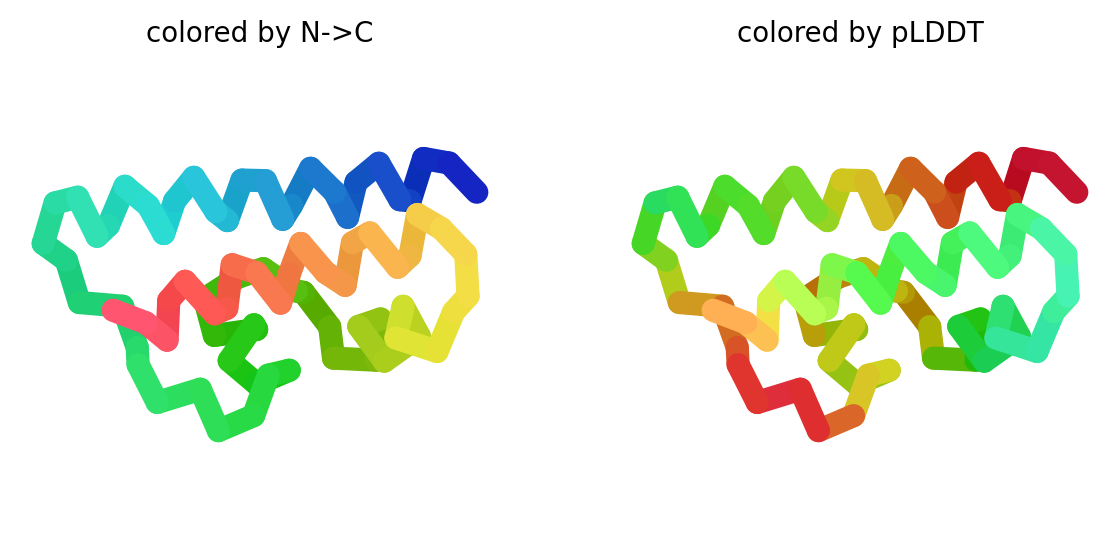

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 53.31, 'Contact %': 1.12, 'Diff volume': 36.93, 'ConFactor': ('Unstable', 1, 0.0)}
INFO:Logger:[MCLOG]: Step: 2101, New Loss: 0.479, Curr Loss: 0.059, Best Loss: 0.008, Accepted: × with temp 4.3 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 44.29, 'Contact %': 0.94}
INFO:Logger:[MCLOG]: Step: 2102, New Loss: 0.832, Curr Loss: 0.059, Best Loss: 0.008, Accepted: × with temp 4.5 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 50.41, 'Contact %': 1.19, 'Diff volume': 99.8, 'ConFactor': (0.18, 0.65, 0.01)}
INFO:Logger:[MCLOG]: Step: 2103, New Loss: 0.370, Curr Loss: 0.059, Best Loss: 0.008, Accepted: × with temp 4.7 and prob 0.001
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 62.1, 'Contact %': 2.09, 'Diff volume': 63.72, 'ConFactor': (0.08, 0.07, 0.0)}
INFO:Logger:[MCLOG]: Step: 2104, New Loss: 0.059, Curr Loss: 0.059, Best Loss: 0.008, Accepted: √ with temp 4.9

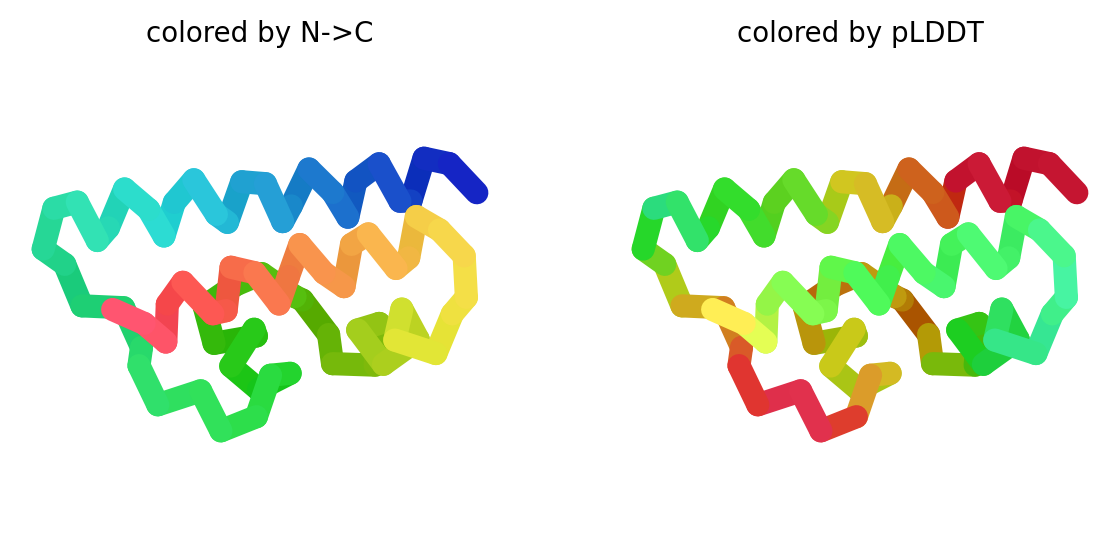

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 48.69, 'Contact %': 0.76}
INFO:Logger:[MCLOG]: Step: 2201, New Loss: 0.846, Curr Loss: 0.048, Best Loss: 0.008, Accepted: × with temp 1.8 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 45.9, 'Contact %': 1.08}
INFO:Logger:[MCLOG]: Step: 2202, New Loss: 0.811, Curr Loss: 0.048, Best Loss: 0.008, Accepted: × with temp 1.9 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 49.96, 'Contact %': 0.83}
INFO:Logger:[MCLOG]: Step: 2203, New Loss: 0.834, Curr Loss: 0.048, Best Loss: 0.008, Accepted: × with temp 2.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 50.5, 'Contact %': 1.05, 'Diff volume': 248.19, 'ConFactor': (0.07, 0.1, 0.06)}
INFO:Logger:[MCLOG]: Step: 2204, New Loss: 0.231, Curr Loss: 0.048, Best Loss: 0.008, Accepted: × with temp 2.1 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 51.4, 'Contact %': 1.33, 'Error': '

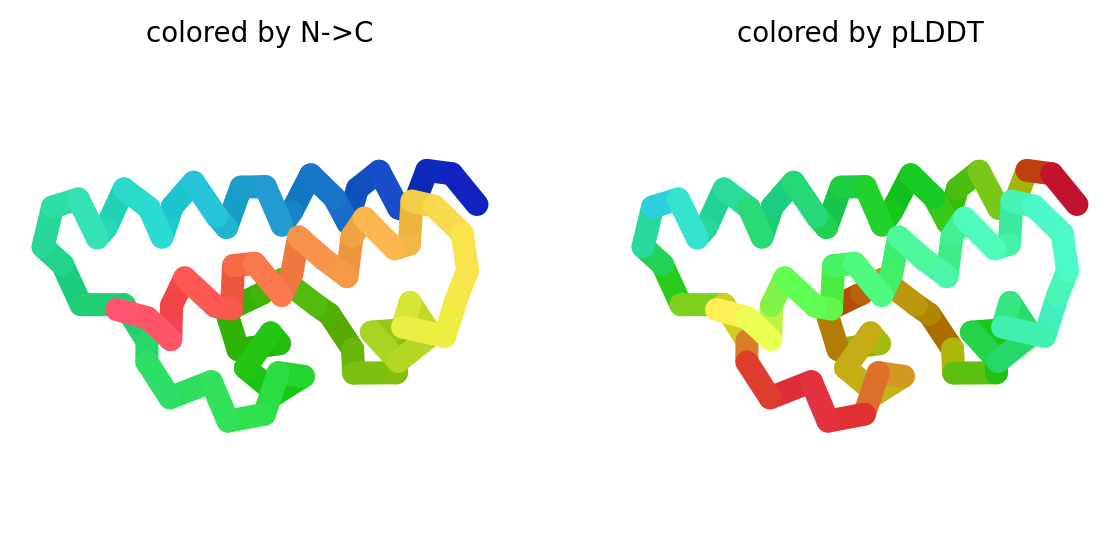

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 53.94, 'Contact %': 1.01, 'Diff volume': 150.33, 'ConFactor': (0.88, 1, 1)}
INFO:Logger:[MCLOG]: Step: 2301, New Loss: 0.803, Curr Loss: 0.063, Best Loss: 0.008, Accepted: × with temp 1.1 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 50.68, 'Contact %': 0.72, 'Diff volume': 481.9, 'ConFactor': (0.25, 1, 0.45)}
INFO:Logger:[MCLOG]: Step: 2302, New Loss: 0.673, Curr Loss: 0.063, Best Loss: 0.008, Accepted: × with temp 1.1 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 53.24, 'Contact %': 1.26, 'Diff volume': 247.54, 'ConFactor': (0.54, 1, 1)}
INFO:Logger:[MCLOG]: Step: 2303, New Loss: 0.773, Curr Loss: 0.063, Best Loss: 0.008, Accepted: × with temp 1.1 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 52.06, 'Contact %': 1.01, 'Diff volume': 332.0, 'ConFactor': (0.08, 0.09, 0.15)}
INFO:Logger:[MCLOG]: Step: 2304, New Loss: 0.257, Curr Loss: 0.063, 

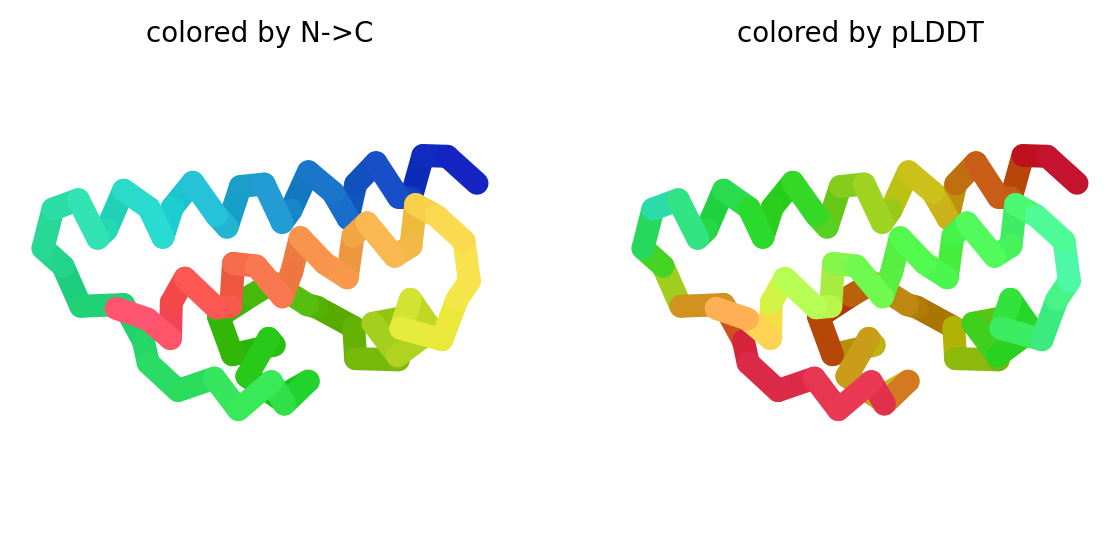

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 63.58, 'Contact %': 1.95, 'Diff volume': 56.38, 'ConFactor': (0.16, 0.23, 0.0)}
INFO:Logger:[MCLOG]: Step: 2401, New Loss: 0.115, Curr Loss: 0.054, Best Loss: 0.008, Accepted: × with temp 1.0 and prob 0.002
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 69.51, 'Contact %': 2.02, 'Diff volume': 22.68, 'ConFactor': (0.15, 0.18, 0.0)}
INFO:Logger:[MCLOG]: Step: 2402, New Loss: 0.078, Curr Loss: 0.054, Best Loss: 0.008, Accepted: × with temp 1.0 and prob 0.094
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 47.54, 'Contact %': 0.72}
INFO:Logger:[MCLOG]: Step: 2403, New Loss: 0.853, Curr Loss: 0.054, Best Loss: 0.008, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 55.0, 'Contact %': 1.15, 'Diff volume': 41.26, 'ConFactor': (0.28, 1, 0.0)}
INFO:Logger:[MCLOG]: Step: 2404, New Loss: 0.471, Curr Loss: 0.054, Best Loss: 0.008, Accepted: × with temp 1.0 and p

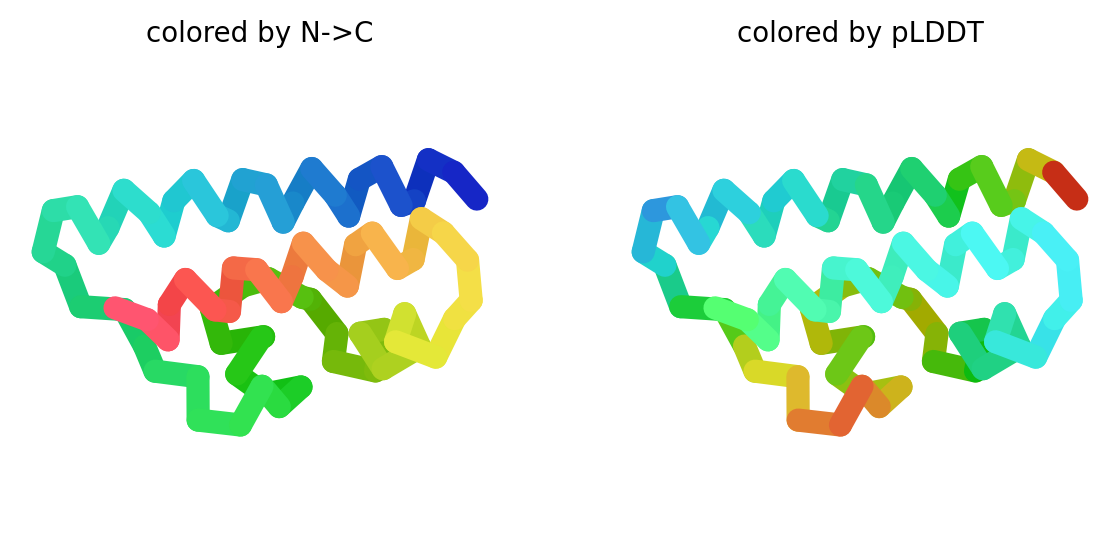

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 48.31, 'Contact %': 0.97}
INFO:Logger:[MCLOG]: Step: 2501, New Loss: 0.819, Curr Loss: 0.030, Best Loss: 0.008, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 67.65, 'Contact %': 1.62, 'Diff volume': 56.8, 'ConFactor': (0.43, 1, 1)}
INFO:Logger:[MCLOG]: Step: 2502, New Loss: 0.698, Curr Loss: 0.030, Best Loss: 0.008, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 50.81, 'Contact %': 0.61, 'Diff volume': 445.83, 'ConFactor': (0.13, 0.27, 0.36)}
INFO:Logger:[MCLOG]: Step: 2503, New Loss: 0.431, Curr Loss: 0.030, Best Loss: 0.008, Accepted: × with temp 1.0 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 54.38, 'Contact %': 1.73, 'Diff volume': 184.47, 'ConFactor': (0.19, 0.75, 0.03)}
INFO:Logger:[MCLOG]: Step: 2504, New Loss: 0.330, Curr Loss: 0.030, Best Loss: 0.008, Accepted: × with temp 1.0 and

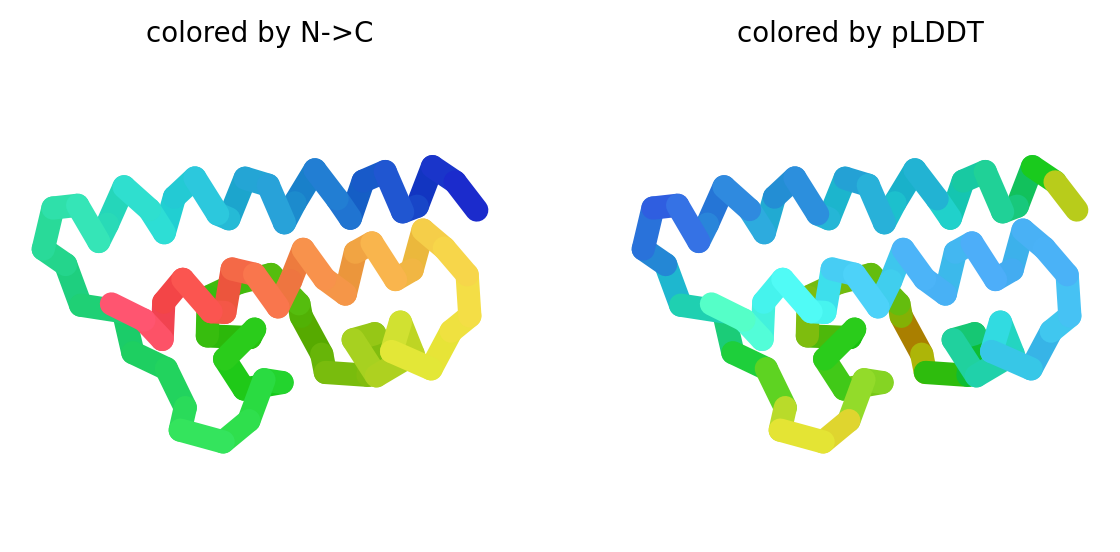

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 68.7, 'Contact %': 1.8, 'Diff volume': 23.33, 'ConFactor': (0.13, 0.18, 0.0)}
INFO:Logger:[MCLOG]: Step: 2601, New Loss: 0.105, Curr Loss: 0.024, Best Loss: 0.008, Accepted: × with temp 2.0 and prob 0.017
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 51.88, 'Contact %': 0.86, 'Diff volume': 171.94, 'ConFactor': (0.07, 0.1, 0.02)}
INFO:Logger:[MCLOG]: Step: 2602, New Loss: 0.238, Curr Loss: 0.024, Best Loss: 0.008, Accepted: × with temp 2.1 and prob 0.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 52.64, 'Contact %': 1.37, 'Diff volume': 93.1, 'ConFactor': (0.09, 0.13, 0.01)}
INFO:Logger:[MCLOG]: Step: 2603, New Loss: 0.177, Curr Loss: 0.024, Best Loss: 0.008, Accepted: × with temp 2.2 and prob 0.001
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 50.42, 'Contact %': 1.69, 'Diff volume': 163.3, 'ConFactor': (0.08, 0.14, 0.02)}
INFO:Logger:[MCLOG]: Step: 2604, New Loss: 0.151, Curr Loss

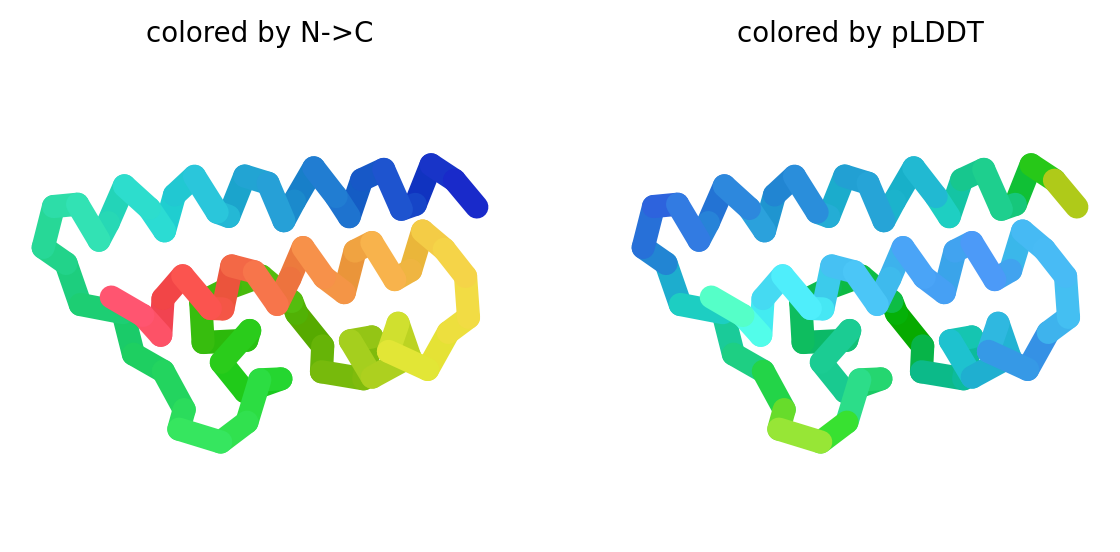

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 80.35, 'Contact %': 2.2, 'Diff volume': 71.93, 'ConFactor': (0.05, 0.02, 0.0)}


[JODID]: Job finished with id:fb606c9a


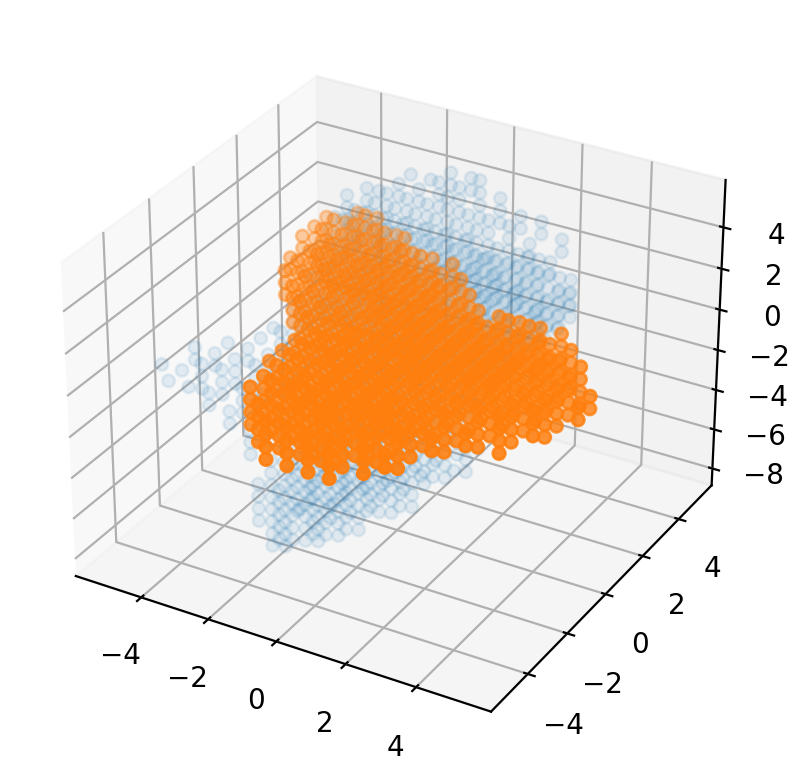

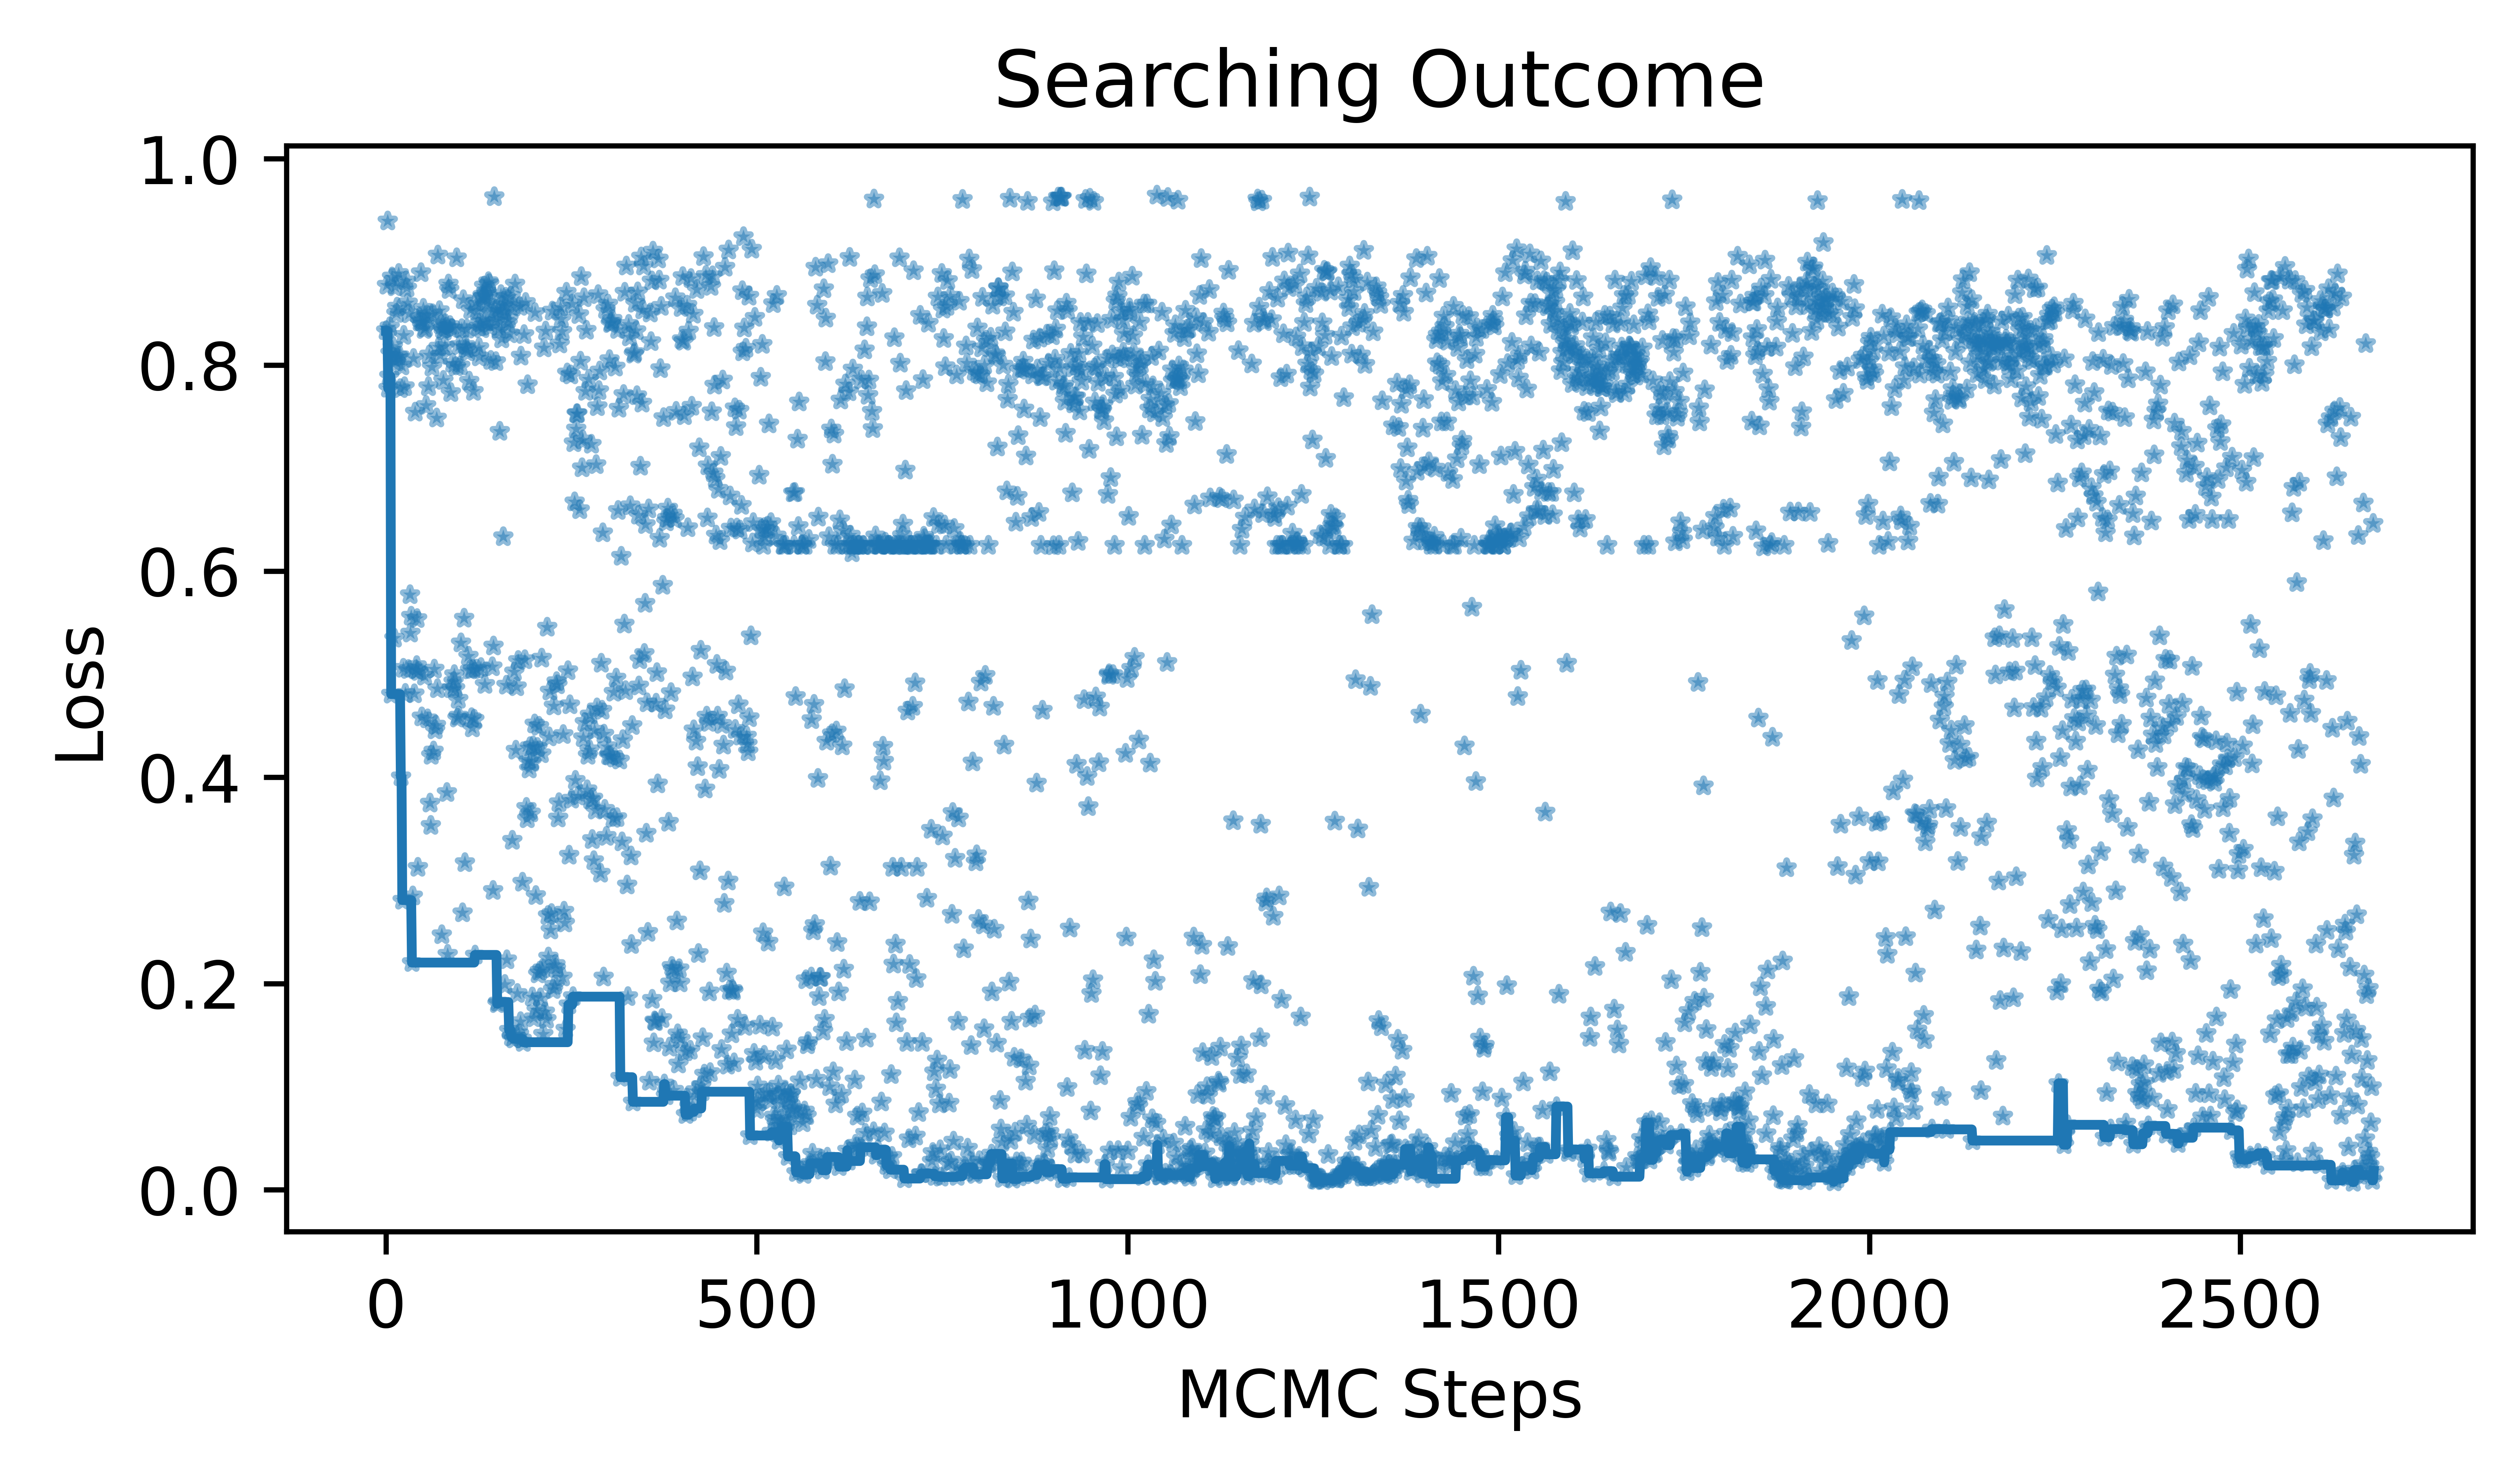

In [ ]:
#@title Start Hallucinating!

import gc
import torch
import numpy as np

if 'logger' in dir():
  del logger

if torch.cuda.is_available():
  torch.cuda.empty_cache()

gc.collect()

seqc = Initial_Sequence if Start_From_Known_Sequence else None
exaa = Exclude_Amino_Acid.split(';')
job_name = None if Jobname == 'UUID4' else Jobname
pres_resid = Preserved_Residues.split(';') if Start_From_Known_Sequence else None

logger = Protein_History_MCMC_Logger(
        length=Length, excluded_aas=exaa, temp=[.05, .01, (1e-9, 5)], step=Steps,
        free_guess=N_Free_Guess, seqc_provided=seqc, preserve_resid=pres_resid,
        temp_control='Adaptive', job_name=job_name,
        guess_loss_ignore=['TruncatedAveragePLDDTLoss', 'MoleculeBindingAffinityLoss'],
        plddt_loss=PLDDTLoss, pos_loss=POSLoss,
        form_loss=lambda x, y: x+y, plddt_rule=np.mean,
        pos_rule=np.sum if Loss_Rule=='Sum' else np.max,
        loss_info=True, server_online=(useESMFold=='online'))

logger.mcmc(print_level=Output_Render_Frequency, allow_convergence=0)
